# TP2: From coordinate descent to second order methods

#### Authors: O. Fercoq, S. Gaiffas, A. Gramfort

The aim of this material is to go beyond gradient methods to tackle regression and classification optimization problems.

This will cover:

- Part 1 : Coordinate descent for the Lasso problem
- Part 2 : Newton method with and without Armijo line-search on Logistic regression
- Part 3 : L-BFGS on Logistic regression

This work should be done by pairs of students. One document for each pair of students should be sent to:

alexandre.gramfort@telecom-paristech.fr

**PLEASE use as object/title for your email "TP2-DS-Optim"**

In [1]:
# to embed figures in the notebook
%matplotlib inline

## Part 1 : Coordinate descent for the lasso

We'll start by generating sparse vectors and simulating data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

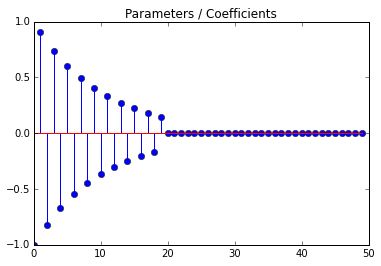

In [3]:
n_features = 50
n_samples = 2000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

In [4]:
# Simulation of the features matrix
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz

# Correlation
rho = 0.7

# Construction of a covariance matrix
cov = toeplitz(rho ** np.arange(0, n_features))

# Simulation of Gaussian vectors with this covariance matrix (it will be the features)
A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)

from numpy.random import randn

# Simulation of a linear model
std = 1.
noise = std * randn(n_samples)

# Simulation of the labels according to the linear regression model : b = A coefs + noise
b = A.dot(coefs) + noise

print(A.shape)
print(b.shape)

(2000, 50)
(2000,)


### Coordinate Descent on Lasso problem

We consider the following optimization problem:
$$
\arg\min_x \frac{1}{2} \| b - A x \|^2 + \lambda \|x\|_1
$$

## Questions

- Write the formula of one coefficient update when running a proximal coordinate descent.
- Implement a proximal coordinate descent solver based on the code skeleton below. You will use a cyclic selection of the coordinates.

In [5]:
# TODO

from scipy import linalg


def lasso_coord_descent(x0, A, b, l_l1=0., n_iter=50):
    """Coordinate descent solver for the Lasso
    
    Parameters
    ----------
    x0 : array, shape (n_features,)
    A : array, shape (n_samples, n_features)
    b : array, shape (n_samples,)
    l_l1 : float
        The lambda regularization parameter
    n_iter : int
        The number of iterations over the full dataset.
        n_features * n_iter coordinate updates will be done.
    
    Returns
    -------
    x : array, shape (n_features,)
    objectives : array, shape (n_iter + 1,)
        The value of the primal objective function at the beginning
        and after each pass on all features.
    errors : array, shape (n_iter + 1,)
        The value of the estimation error at the beginning and after each
        pass on all features.
    """
    
    n_samples, n_features = A.shape
    x = x0.copy()
    x_new = x0.copy()
    # Vector that'll contain the residuals
    r = b - np.dot(A, x0)
    errors = []
    objectives = []
    err = linalg.norm(x - coefs) / linalg.norm(coefs)
    errors.append(err)
    
    def compute_obj(x):
        return 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l_l1 * np.sum(np.abs(x))
    
    objectives.append(compute_obj(x))
    print("")    
    print("Lauching coordinate descent solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter):
        # Cycle over the coordinates
        for j in range(n_features):
            pass
            # x[j] = TODO
            # r = TODO
        obj = compute_obj(x)
        err = linalg.norm(x - coefs) / linalg.norm(coefs)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0:
            print (' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [7]:
x0 = np.zeros(n_features)
n_iter = 40
l_l1=5e-2
x_cd, obj_cd, err_cd = lasso_coord_descent(x0, A, b, l_l1=l_l1, n_iter=n_iter)


Lauching coordinate descent solver...
   it    |   obj    |   err   
       0 | 1.60e+03 | 7.73e-01
      10 | 1.22e+03 | 4.86e-01
      20 | 1.22e+03 | 4.82e-01
      30 | 1.22e+03 | 4.82e-01


# Let's monitor convergence

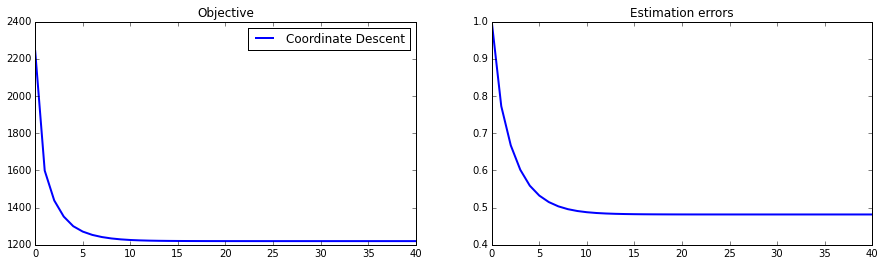

In [8]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.plot(obj_cd, label="Coordinate Descent", lw=2)
plt.title("Objective")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(err_cd, label="Coordinate Descent", lw=2)
plt.title("Estimation errors")

# Part 2 : Newton method

We are now investigating the logistic regression model in the context of binary classification.

We'll use the famous IRIS dataset provided by Scikit-Learn.

We'll denote by $n$ (or `n_samples`) the number of samples and $p$ (or `n_features`) the number of features, i.e. the dimension of the samples.

For the data below we'll have $p=2$.

## Part 2.0 : The data

(100,)
(100, 2)


/Users/alex/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


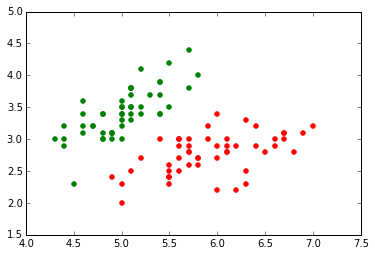

In [9]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Take only 2 features to make visualization easy
X = X[:, :2]

# Make it binary
X = X[y < 2]
y = y[y < 2]

y[y == 0] = -1

print(y.shape)
print(X.shape)

plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')

## Part 2.1 : Logistic Regression

When we use the convention that $y=1$ for the positive class and $y=-1$ for the negative class
the L2 penalized logistic regression model reads:

$$
\hat{w}, \hat{b} = \mathop{\textrm{argmin}}_{w, b} \sum_{i=1}^n \log(1 + \exp(- y_i (x_i^\top w + b)))) + \lambda \|w\|^2
$$

where $w$ is a vector of coefficients of size $p$, $b$ is a scalar intercept and $\lambda > 0$ is a regularization parameter.

Then the prediction for a new sample is given by :

$$
y_{pred} = \textrm{sign}(x^\top w + b)
$$

In a first step we ignore the intercept and consider the function:

$$f(w) = \sum_{i=1}^n \log(1 + \exp(- y_i (x_i^\top w)))) + \lambda \|w\|^2$$

## Questions

   - Write the formulas for the gradient and the Hessian matrix of $f$ at point $w$
   - Implement both and use the `scipy.optimize.check_grad` function from scipy to check your implementation of the gradient.
   - Implement a Newton solver for minimizing $f$.

In [10]:
# TODO

def pobj_logistic(X, y, w, alpha):
    # TODO
    return pobj


def grad_logistic(X, y, w, alpha):
    # TODO
    return grad


def hess_logistic(X, y, w, alpha):
    # TODO
    return hess


def newton_logistic(X, y, alpha=1., w0=None):
    X = np.asarray(X, dtype=np.float)
    y = np.asarray(y, dtype=np.float)

    if w0 is None:
        w0 = np.zeros(X.shape[1])

    n_samples, n_features = X.shape
    
    w = w0.copy()
    
    pobj = []
    
    print("")    
    print("Lauching Newton solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj"]]))

    for k in xrange(20):
    
        grad = grad_logistic(X, y, w, alpha)
        hess = hess_logistic(X, y, w, alpha)

        # TODO : write the w update using grad and hess

        this_pobj = pobj_logistic(X, y, w, alpha)
        pobj.append(this_pobj)
        
        print (' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % this_pobj).rjust(8)]))

    print("Global minimum : %s" % pobj[-1])

    return w, pobj

In [12]:
alpha = 0.1
w, pobj = newton_logistic(X, y, alpha=alpha)


Lauching Newton solver...
   it    |   obj   
       0 | 2.25e+01
       1 | 1.34e+01
       2 | 1.08e+01
       3 | 1.05e+01
       4 | 1.05e+01
       5 | 1.05e+01
       6 | 1.05e+01
       7 | 1.05e+01
       8 | 1.05e+01
       9 | 1.05e+01
      10 | 1.05e+01
      11 | 1.05e+01
      12 | 1.05e+01
      13 | 1.05e+01
      14 | 1.05e+01
      15 | 1.05e+01
      16 | 1.05e+01
      17 | 1.05e+01
      18 | 1.05e+01
      19 | 1.05e+01
Global minimum : 10.4934020083


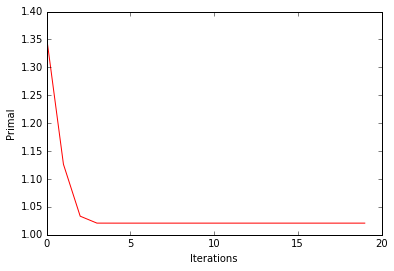

In [13]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

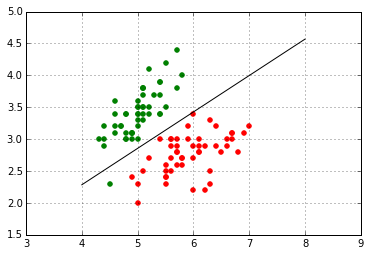

In [14]:
def plot_coefs(w, b=0.0):
    plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
    plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')
    xx = np.linspace(4, 8, 10)
    plt.plot(xx,  - xx * w[0] / w[1] - b / w[1], 'k')
    plt.grid('on')

plot_coefs(w)

To take into acccount the intercept we propose to add a column of 1 to the matrix X.

In [15]:
X1 = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

## Questions

    - Modify the solver so it does not penalize the intercept now present via the last column of X1

In [16]:
# TODO

def newton_logistic_intercept(X1, y, alpha=1., w0=None):
    X = X1

    X = np.asarray(X, dtype=np.float)
    y = np.asarray(y, dtype=np.float)

    if w0 is None:
        w0 = np.zeros(X.shape[1])

    n_samples, n_features = X.shape
    
    w = w0
    
    pobj = []
    
    print("")    
    print("Lauching Newton solver...")
    print(' | '.join([name.center(8) for name in ["it", "obj"]]))

    for k in xrange(20):
        # TODO

        print (' | '.join( [ ("%d" % k).rjust(8), ("%.8e" % this_pobj).rjust(8)]))

    print("Global minimum : %s" % pobj[-1])

    b = w[-1]
    w = w[:-1]
    return w, b, pobj

In [18]:
alpha = 0.1
w, b, pobj = newton_logistic_intercept(X1, y, alpha=alpha)


Lauching Newton solver...
   it    |   obj   
       0 | 2.16494714e+01
       1 | 1.19095906e+01
       2 | 8.57272846e+00
       3 | 7.84279210e+00
       4 | 7.79603650e+00
       5 | 7.79580037e+00
       6 | 7.79580036e+00
       7 | 7.79580036e+00
       8 | 7.79580036e+00
       9 | 7.79580036e+00
      10 | 7.79580036e+00
      11 | 7.79580036e+00
      12 | 7.79580036e+00
      13 | 7.79580036e+00
      14 | 7.79580036e+00
      15 | 7.79580036e+00
      16 | 7.79580036e+00
      17 | 7.79580036e+00
      18 | 7.79580036e+00
      19 | 7.79580036e+00
Global minimum : 7.79580036063


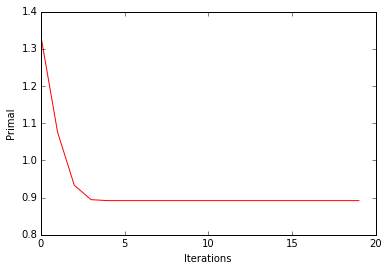

In [19]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

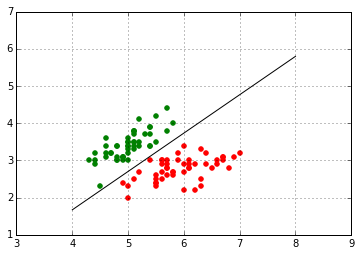

In [20]:
plot_coefs(w, b)

## Part 2.2 Newton with line search

Newton's method is only proven to converge in a neighborhood of the minimizer.

## Questions

    - Try the method newton_logistic_intercept with w0 = 0.3 * np.ones(X1.shape[1]) as a starting point.
    - What do you observe?

### Armijo's Line search

To overcome the instability of Newton's method when we are not in the neighbourhood of the optimum, we implement a line search that guarantees that the function value will decrease at each iteration and this leads to convergence whatever the initial point.

We recall Armijo's rule. We fix $s > 0$, $\sigma \in (0,1)$ and $\beta \in (0,1)$. For a given $w_t$ and a descent direction $d_t$, we look for $m_t$ which is the first integer $m$ such that
$$
f(w_t + s \beta^m d_t) - f(w_t) \leq  \sigma s \beta^m \nabla f(w_t)^\top d_t
$$
The new iterate is then $w_{t+1} = w_t + s \beta^{m_t} d_t$.

We shall take $d_t$ equal to Newton's update, $s=1$, $\beta = 0.5$ and $\sigma = 10^{-4}$.

## Questions

  - Modify newton_logistic_intercept to implement Armijo's line search.
  - Does the algorithm converge for w0 = 0.3 * np.ones(X1.shape[1])

In [22]:
# TODO

def newton_logistic_intercept_with_linesearch(X, y, alpha=1., w0=None):
    X = np.asarray(X, dtype=np.float)
    y = np.asarray(y, dtype=np.float)

    if w0 is None:
        w0 = np.zeros(X.shape[1])
    
    n_samples, n_features = X.shape
    
    w = w0
    
    pobj = []
    
    print("")    
    print("Lauching Newton solver with line search...")
    print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    
    for k in range(20):
        # Compute descent direction with newton rule
        # descent_direction = TODO
        
        # line search
        test = False
        previous_pobj = pobj_logistic_intercept(X, y, w, alpha)
        
        stepsize = 1.
        step_decrease_rate = 0.5
        sigma = 1e-4
        while not test:
            # w_trial = TODO

            this_grad = grad_logistic_intercept(X, y, w_trial, alpha)
            this_pobj = pobj_logistic_intercept(X, y, w_trial, alpha)
            
            # test = TODO
            
            stepsize *= step_decrease_rate
            
            if stepsize < 1e-10:
                print("line search failed")
                break
            
        w[:] = w_trial
        pobj.append(this_pobj)
        
        print (' | '.join( [ ("%d" % k).rjust(8), ("%.8e" % this_pobj).rjust(8)]))

    print("Global minimum : %s" % pobj[-1])

    b = w[-1]
    w = w[:-1]
    return w, b, pobj

In [24]:
alpha = 0.1
w, b, pobj = newton_logistic_intercept_with_linesearch(X1, y, alpha=alpha, w0=0.3 * np.ones(X1.shape[1]))


Lauching Newton solver with line search...
   it    |   obj   
       0 | 5.40717287e+01
       1 | 3.46089858e+01
       2 | 1.37786867e+01
       3 | 8.98540739e+00
       4 | 7.89289339e+00
       5 | 7.79687437e+00
       6 | 7.79580054e+00
       7 | 7.79580036e+00
       8 | 7.79580036e+00
       9 | 7.79580036e+00
      10 | 7.79580036e+00
      11 | 7.79580036e+00
      12 | 7.79580036e+00
      13 | 7.79580036e+00
      14 | 7.79580036e+00
      15 | 7.79580036e+00
      16 | 7.79580036e+00
      17 | 7.79580036e+00
      18 | 7.79580036e+00
      19 | 7.79580036e+00
Global minimum : 7.79580036063


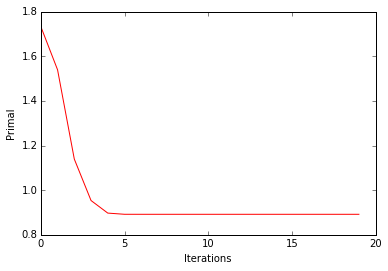

In [25]:
plt.plot(np.log10(pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

# Part 3 : L-BFGS

So far you have implemented your own solvers. In this last part you'll simply learn out to use
an existing solver. You'll be using `scipy.optimize.fmin_l_bfgs_b`.


## Question

   - Minimize the Logistic regression problem, taking into account the intercept using the `scipy.optimize.fmin_l_bfgs_b` function.

In [26]:
# TODO

all_pobj = []

def f(w):
    # pobj = TODO
    all_pobj.append(pobj)
    return pobj

def fprime(w):
    # grad = TODO
    return grad

from scipy.optimize import fmin_l_bfgs_b

# TODO

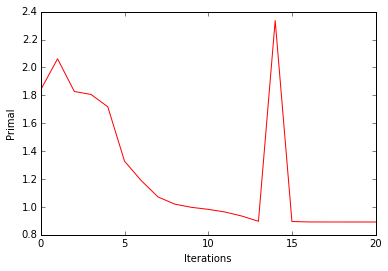

In [28]:
plt.plot(np.log10(all_pobj), 'r')
plt.xlabel('Iterations')
plt.ylabel('Primal')
plt.show()

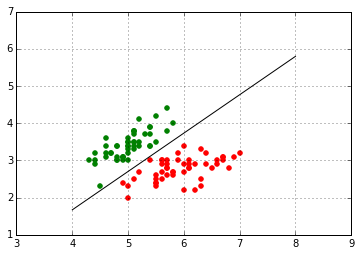

In [29]:
plot_coefs(w, b)

## Bonus Question

in case you're done early ...

   - Evaluate the performance of your implementation against sklearn.linear_model.LogisticRegression on the digits dataset.